In [19]:
# 라이브러리

import pandas as pd ; pd.options.display.float_format = '{:.2f}'.format # 소수 둘째자리까지 표시
import numpy as np
import math

import time
from time import sleep
import random
import datetime
from datetime import datetime, timedelta, datetime
import json

from string import ascii_lowercase

import collections
from dateutil.relativedelta import relativedelta

from powernad.API.Campaign import *
from powernad.API.RelKwdStat import *

from urllib.error import HTTPError
import urllib.request

from bs4 import BeautifulSoup ; import bs4
from selenium import webdriver
import psycopg2
import re

from tqdm.notebook import tqdm

import requests; from urllib.parse import urlparse
import seaborn as sns; sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2) ; sns.set_color_codes()

import matplotlib; import matplotlib.pyplot as plt

import squarify


# 네트워크 시각화용
import warnings
warnings.filterwarnings(action='ignore')

# from matplotlib import font_manager, rc
# from matplotlib import style
# style.use('ggplot')
# %matplotlib inline


# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf", size=20).get_name()
# rc('font', family=font_name)
# plt.rcParams['axes.unicode_minus'] = False

# 구간날짜 변수 생성

In [20]:
"""
날짜 구간 정보가 들어있는 변수들을 생성합니다.
이 변수들을 활용해 날짜 구간을 기준으로 매일 데이터를 갱신합니다.
...
----------------------------------
today = 현재
today = 오늘자 년월일 문자열
yesterday = 어제 
time_week = 7일 전
time_month = 1개월 전
time_year = 1년 전
time_two_years = 2년 전
time_three_years = 3년 전
"날짜구간 변수명"_index = 날짜구간 인덱스
dt_"날짜구간" = 날짜구간 인덱스를 리스트 형태로 
"""

# 오늘
toda = datetime.now()
today = str(datetime.now().date()) # 


# 1일 전
yesterday = toda - relativedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')
yesterday = str(yesterday)


# 1주
time_week = toda - relativedelta(weeks=1)
time_week = time_week.strftime('%Y-%m-%d')
time_week = str(time_week)
# 최근 1주 리스트
week_index = pd.date_range(start=time_week, end= yesterday)
dt_week = week_index.strftime("%Y-%m-%d").tolist()


# 1개월
time_month = toda - relativedelta(months=1)
time_month = time_month.strftime('%Y-%m-%d')
time_month= str(time_month)
# 최근 1개월 리스트
month_index = pd.date_range(start=time_month, end= yesterday)
dt_month = month_index.strftime("%Y-%m-%d").tolist()


# 1년
time_year = toda - relativedelta(years=1)
time_year = time_year.strftime('%Y-%m-%d')
time_year= str(time_year)
# 최근 1년 리스트
year_index = pd.date_range(start=time_year, end= yesterday)
dt_year = year_index.strftime("%Y-%m-%d").tolist()


# 2년
time_two_years = toda - relativedelta(years=2)
time_two_years = time_two_years.strftime('%Y-%m-%d')
time_two_years = str(time_two_years)
# 최근 2년 리스트
two_years_index = pd.date_range(start=time_two_years, end= yesterday)
dt_two_years = two_years_index.strftime("%Y-%m-%d").tolist()

# 3년
time_three_years = toda - relativedelta(years=3)
time_three_years = time_three_years.strftime('%Y-%m-%d')
time_three_years = str(time_three_years)
# 최근 3년 리스트
three_years_index = pd.date_range(start=time_three_years, end= yesterday)
dt_three_years = three_years_index.strftime("%Y-%m-%d").tolist()

In [21]:
# df_origin
"""
네이버 데이터랩 쇼핑인사이트 기준 일자별 패션의류 카테고리 검색랭킹 500위에 포함된 키워드 정보가 있는 데이터프레임입니다.
데이터 시작일 = 2017-08-01
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""
df_origin = pd.read_csv('C:/project/CODE/keyword/data/furniture/naver_top_500/' + yesterday + '_data.csv', header = None, encoding='utf-8', index_col=0)
df_origin.columns = ['rank', 'keyword', 'year', 'month', 'day', 'ymd']
df_origin = df_origin.sort_values(by=['ymd', 'rank'])
df_origin = df_origin.reset_index(drop=True)
df_origin

,rank,keyword,year,month,day,ymd
0,1,화장대,2017,8,1,2017-08-01
1,2,책상,2017,8,1,2017-08-01
2,3,쇼파,2017,8,1,2017-08-01
3,4,침대,2017,8,1,2017-08-01
4,5,책장,2017,8,1,2017-08-01
...,...,...,...,...,...,...
773841,495,벽걸이led시계,2022,6,12,2022-06-12
773842,496,소파패드,2022,6,12,2022-06-12
773843,497,창문가리개,2022,6,12,2022-06-12
773844,499,양면암막커튼,2022,6,12,2022-06-12


In [22]:
# df
"""
개별 키워드들의 날짜 정보가 가장 오래된(키워드가 최초 랭크인한 날) 행을 1개만 남기고 나머지 중복값을 모두 삭제한 데이터프레임입니다.
기존에 검색어 랭킹 500위 이내에 없던 키워드가 최초로 랭크된 것은 순간적으로 해당 키워드에 대한 관심도가 증가했다고 볼 수 있습니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df = df_origin.drop_duplicates(['keyword'], keep='first')
df = df.reset_index(drop=True)
df

,rank,keyword,year,month,day,ymd
0,1,화장대,2017,8,1,2017-08-01
1,2,책상,2017,8,1,2017-08-01
2,3,쇼파,2017,8,1,2017-08-01
3,4,침대,2017,8,1,2017-08-01
4,5,책장,2017,8,1,2017-08-01
...,...,...,...,...,...,...
5824,489,거실화장실극세사발매트,2022,6,11,2022-06-11
5825,87,시스템신발장모자,2022,6,12,2022-06-12
5826,93,접이식침대4단각도조절,2022,6,12,2022-06-12
5827,410,시스템선반,2022,6,12,2022-06-12


In [23]:
# df_monthly_keywords
"""
최초등장일이 최근 1개월 이내인 키워드들만 보여주는 데이터프레임입니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df_monthly_keywords = df.query('ymd == @dt_month')
df_monthly_keywords = df_monthly_keywords.reset_index(drop=True)
df_monthly_keywords 

,rank,keyword,year,month,day,ymd
0,72,실내용디퓨저byldf001천연디퓨저,2022,5,13,2022-05-13
1,74,천연디퓨저실내용디퓨저byldf001,2022,5,13,2022-05-13
2,75,헤링본여름쿨매트,2022,5,13,2022-05-13
3,83,천연디퓨저디퓨저byldf001실내용,2022,5,13,2022-05-13
4,84,실내용byldf001천연디퓨저디퓨저,2022,5,13,2022-05-13
...,...,...,...,...,...,...
312,489,거실화장실극세사발매트,2022,6,11,2022-06-11
313,87,시스템신발장모자,2022,6,12,2022-06-12
314,93,접이식침대4단각도조절,2022,6,12,2022-06-12
315,410,시스템선반,2022,6,12,2022-06-12


In [24]:
# lis
"""
최초등장일이 최근 1개월 이내인 키워드들이 담긴 리스트를 생성합니다.
"""
lis = list(df_monthly_keywords['keyword'])
len(lis)

317

# 키워드 검색량 조회용 네이버 API

In [25]:
# Naver API 조회용 기본 설정
"""
네이버 광고 API 정보를 조회하기 위한 변수입니다.
...
BASE_URL = 네이버 API 주소
API_KEY = 네이버 검색광고 API 엑세스 라이선스
SECRET_KEY = 네이버 검색광고 API SECRET
CUSTOMER_ID = 네이버 검색광고 API ID
rel = 클라이언트 정보 저장 변수
"""

BASE_URL = 'https://api.naver.com'
API_KEY = '01000000000fcd1ce283f84b5b3f32330368ac6dce35c5a8e3feabf4cfec31ae32b7e9d0e8'
SECRET_KEY = 'AQAAAAAPzRzig/hLWz8yMwNorG3OPks1JGYBp40Ib+rqqydacA=='
CUSTOMER_ID = '2488417'
rel = RelKwdStat(BASE_URL, API_KEY, SECRET_KEY, CUSTOMER_ID)

In [26]:
# search_keyword
def search_keyword(searchword):
    """
    네이버 API 키워드 월간 검색수를 반환해주는 함수입니다.
    ...
    searchword = API 정보를 조회할 키워드명
    """
    
    # kwdDataList = 키워드 검색 정보를 담은 변수입니다.
    kwdDataList = rel.get_rel_kwd_stat_list(siteId=None, biztpId=None, hintKeywords=searchword, event=None, month=None, showDetail='1')

    # kwd_result
    
    '''
    kwdDataList[0].relKeyword = 키워드
    kwdDataList[0].monthlyPcQcCnt = 월간 검색수 (PC)
    kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (Mobile)
    kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (total)
    '''
    kwd_result = (kwdDataList[0].relKeyword,
                 kwdDataList[0].monthlyPcQcCnt,
                 kwdDataList[0].monthlyMobileQcCnt,
                 kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt)
    
    # kwd_result[3] = 검색한 키워드명과 월간 pc, 모바일, 총 검색수를 반환합니다
    return(kwd_result[3])

# 네이버 데이터랩 (검색어트렌드) 클라이언트 정보
'''
client_id = 네이버 데이터랩 (검색어트렌드) id
client_secret = 네이버 데이터랩 (검색어트렌드) secret
'''
client_id = "IZr05hqQauLB_l9gJEFG"  
client_secret = "cARLdhpO5W"  

In [27]:
# 키워드별 검색량 저장용 자료구조 생성
'''
dictionary_yester = 전일 키워드 검색량 / 딕셔너리
dictionary_now = 오늘자 키워드 검색량  / 딕셔너리
error = 에러 확인 / 리스트
df_total = 일자별 키워드 검색량 / 데이터프레임
'''
dictionary_yester={}
dictionary_now={}
error=[]
df_total = pd.DataFrame(columns=['키워드', '날짜', '수집날짜', '검색량'])


In [34]:
# serach_query
def search_query(list_name):
    """
    위에서 선언한 search_keyword() 함수를 통해 각 키워드의 월간 총 검색량을 추출한 후, 
    날짜별 검색량으로 전환한 데이터프레임을 생성하는 함수입니다.
    ...
    list_name = 조회하고 싶은 키워드 정보가 들어있는 리스트 이름
    """
    
    global df_total
    for i in tqdm(list_name):  
        print(i)
        sleep(1)
        try:
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)


                url = "https://openapi.naver.com/v1/datalab/search"
                body = "{\"startDate\":\""+time_month+"\",\"endDate\":\""+today+"\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\""+i+"\",\"keywords\":[\""+i+"\"]}]}";
                requested = urllib.request.Request(url)
                requested.add_header("X-Naver-Client-Id", client_id)
                requested.add_header("X-Naver-Client-Secret", client_secret)
                requested.add_header("Content-Type", "application/json")
                response = urllib.request.urlopen(requested, data=body.encode("utf-8"))
                rescode = response.getcode()

                if(rescode==200):
                    response_body = response.read()
                    output_data = response_body.decode('utf-8')
                else:
                    print('Error code:'+ rescode)
                    pass

                # result = API 조회 결과값이 들어있는 변수입니다.
                result = json.loads(output_data)

                # date = a['period'] 에서 최근 1개월간의 날짜 값들을 추출한 리스트를 생성합니다.
                date = [a['period'] for a in result['results'][0]['data']]

                # aa = 날짜와 날짜별 검색량을 추출한 데이터프레임을 생성합니다.
                aa = pd.DataFrame({'date':date, 
                              'querycount':[a['ratio'] for a in result['results'][0]['data']],
                              })

                # 일일 데이터 계산 
                sleep(0.5)
                total = aa['querycount'].sum() 
                
                # 30일간 모든 백분율 값을 더한 후 일자별 실제 검색량을 반환합니다.
                '''
                total = 날짜별 모든 백분율 검색량을 더한 값
                float(a) = 월간 총 검색량 실수화
                x = 각 일자별 검색량
                '''
                aa['검색량'] = aa['querycount'].apply(lambda x :((x / total)*float(a)))


            else : 
                pass

        except (TypeError, IndexError,KeyError,ValueError):
            print(" 타입 or 인덱스 에러,Value 에러:",i)
            error.append(i)
            pass


        except HTTPError:
            print('http 에러:', i )
            error.append(i)
            pass

            #여기부터 새로 코딩
        try: 
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        


                date = pd.DataFrame(data=dt_month, columns=['날짜'])

                spred = pd.merge(date,aa,left_on='날짜',right_on='date',how='outer')
                spred.drop(['date'],inplace=True, axis=1)

                spred.replace(np.nan,0,inplace=True)


                a=[] 

                for j in range(len(spred)) : 
                    a.append(today)


                spred['수집날짜'] = a
                spred['키워드'] = i
                spred = spred[['키워드', '날짜','수집날짜', '검색량']]

                if i in dictionary_yester:

                    pass

                else : 
                    dictionary_yester[i]=[]



                dictionary_now[i]=spred
                df_total = pd.concat([df_total, spred])

            else:
                pass

        except (TypeError, IndexError,KeyError,ValueError):

            pass

        sleep(0.5)
        try :
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        

                if dictionary_yester[i]==[]:
                    dictionary_yester[i] = dictionary_now[i]

                else : 
                    pass 
            else:
                pass


        except (TypeError, IndexError,KeyError):
              pass


        except ValueError:


                yester_df= dictionary_yester[i]
                today_df = dictionary_now[i]


                yester_df.set_index('날짜',inplace=True)

                today_df.set_index('날짜',inplace=True)

                yester_df.update(today_df)


                tmpt = today_df.iloc[-1,:]

                yester_df = yester_df.append(tmpt)

                yester_df.reset_index(inplace=True)
                today_df.reset_index(inplace=True)


                dictionary_yester[i] = yester_df


        except :
            print('API 에러',i)
            error.append(i)


        

        sleep(3)

    df_total['검색량'] = df_total['검색량'].astype(int)
    
    df_total.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_month_furniture_query_by_date.csv', encoding='UTF-8')
    
    return(df_total)

In [35]:
search_query(lis)

  0%|          | 0/317 [00:00<?, ?it/s]

실내용디퓨저byldf001천연디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용디퓨저byldf001천연디퓨저
천연디퓨저실내용디퓨저byldf001
 타입 or 인덱스 에러,Value 에러: 천연디퓨저실내용디퓨저byldf001
헤링본여름쿨매트
 타입 or 인덱스 에러,Value 에러: 헤링본여름쿨매트
천연디퓨저디퓨저byldf001실내용
 타입 or 인덱스 에러,Value 에러: 천연디퓨저디퓨저byldf001실내용
실내용byldf001천연디퓨저디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용byldf001천연디퓨저디퓨저
천연디퓨저디퓨저실내용byldf001
 타입 or 인덱스 에러,Value 에러: 천연디퓨저디퓨저실내용byldf001
실내용byldf001디퓨저천연디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용byldf001디퓨저천연디퓨저
Http status: 429
failed to request
실내용천연디퓨저byldf001디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용천연디퓨저byldf001디퓨저
쪽가위
실내용천연디퓨저디퓨저byldf001
마켓비원목선반
 타입 or 인덱스 에러,Value 에러: 마켓비원목선반
소음재
모래멍
책상컴퓨터의자
양면암막커튼
학생책상의자
메트로캔들워머
 타입 or 인덱스 에러,Value 에러: 메트로캔들워머
릴리4인용세라믹식탁
컴퓨터학생의자
빨아쓰는발매트
헬시메이트블랙라벨기능성메모리폼경추베개
오에스퍼니처osg100컴퓨터게이밍의자
 타입 or 인덱스 에러,Value 에러: 오에스퍼니처osg100컴퓨터게이밍의자
원목4인식탁세트벤치+의자형
 타입 or 인덱스 에러,Value 에러: 원목4인식탁세트벤치+의자형
장미맨숀
Http status: 429
failed to request
전자렌지밥솥오븐수납장선반
 타입 or 인덱스 에러,Value 에러: 전자렌지밥솥오븐수납장선반
Http status: 429
failed to request
전자레인지밥솥오븐선반수납장600
 타입 or 인덱스 에러,Value 에러: 전자레인

시스템신발장모자
 타입 or 인덱스 에러,Value 에러: 시스템신발장모자
접이식침대4단각도조절
 타입 or 인덱스 에러,Value 에러: 접이식침대4단각도조절
시스템선반
친환경종이가구


,키워드,날짜,수집날짜,검색량
0,쪽가위,2022-05-13,2022-06-13,125
1,쪽가위,2022-05-14,2022-06-13,113
2,쪽가위,2022-05-15,2022-06-13,119
3,쪽가위,2022-05-16,2022-06-13,146
4,쪽가위,2022-05-17,2022-06-13,177
...,...,...,...,...
26,친환경종이가구,2022-06-08,2022-06-13,0
27,친환경종이가구,2022-06-09,2022-06-13,0
28,친환경종이가구,2022-06-10,2022-06-13,0
29,친환경종이가구,2022-06-11,2022-06-13,3434


In [ ]:
# df_query
"""
네이버 패션의류 탑 500 에 신규진입한 키워드의 최근 1개월 동안의 일자별 검색량이 있는 데이터프레임입니다.
"""
df_query = df_total
df_query = df_query[['키워드', '날짜', '수집날짜', '검색량']]
df_query = df_query.rename(columns={'키워드':'keyword', '날짜':'ymd', '수집날짜':'search_date', '검색량': 'query'})
df_query['query'] = df_query['query'].astype(int)
df_query

In [ ]:
# df_query_sum
"""
신규키워드들의 최근 1개월 누적 검색량이 있는 데이터프레임입니다.
"""
df_query_sum = df_query[['keyword', 'query']].groupby('keyword').sum()
df_query_sum = df_query_sum.rename(columns = {'query':'query_month'})
df_query_sum.sort_values('query_month', ascending=False)

In [ ]:
# df_query_m
"""
최근 1개월 이내에 키워드 검색 탑 500에 등장한 키워드들의 검색량을 보여주는 데이터프레임입니다.
...
query = 신규 키워드 랭크 진입 당일 검색량
query_month = 신규 키워드의 최근 1개월 누적 검색량
"""

df_query_m = pd.merge(df_monthly_keywords, df_query, on='keyword')
df_query_m = pd.merge(df_query_m, df_query_sum, on = 'keyword')
df_query_m = df_query_m[df_query_m['ymd_x'] == df_query_m['ymd_y']]
df_query_m = df_query_m.drop(['ymd_y'], axis=1).sort_values(['ymd_x', 'rank'])
df_query_m.rename(columns = {'ymd_x':'ymd'},inplace=True)
df_query_m.reset_index(inplace=True, drop=True)

df_query_m

In [ ]:
# df_m
"""
최근 1개월 이내 키워드 검색 탑 500 에 등장한 키워드 정보가 담겨있는 데이터프레임입니다.
*********************** 최종적으로 스트림릿에 추가해야하는 데이터프레임 *************************
"""
df_m = pd.DataFrame({'등장일자':df_query_m['ymd'], '랭킹':df_query_m['rank'], '키워드':df_query_m['keyword'], '일간검색량':df_query_m['query'], '월간검색량':df_query_m['query_month']})
df_m = df_m.sort_values('등장일자', ascending=False)
df_m.to_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8')
df_m.head(50)

In [ ]:
df_m_list = list(df_m['키워드'])

In [ ]:
# keyword_grouping

splitted_list = [['소파']] # splitted_list = 기준 키워드
def keyword_grouping(list_name):
    """
    키워드의 장기간 검색량을 일자별로 수집하는 함수입니다.
    네이버 API는 한번에 5개까지만 키워드를 조회할 수 있는데, 한 번에 5개 이상의 키워드 검색량 정보를 조회합니다.
    단, 네이버 API 를 통해 최근 1개월보다 이전의 검색량을 조회할 경우, 
    검색된 키워드의 검색량이 아니라 조회한 키워드 중 검색량이 가장 많았던 시점을 기준으로 0 ~ 100 사이의 백분율 정보를 제공합니다.
    각 키워드의 실제 검색량이 달라도 같은 100으로 집계되는 경우를 방지하기 위해 5개의 그룹에 항상 포함되는 기준 키워드를 설정했습니다.
    ex)
    ['소파', 'A', 'B', 'C', 'D']
    ['소파', 'E', 'F', 'G', 'H']
    ...
    list_name = 조회할 키워드가 들어있는 리스트명
    """

    # 키워드가 5개씩 순차적으로 들어있는 2차원 리스트 생성 반복문
    # 마지막 리스트가 5개로 떨어지지 않을 경우 '더미' 를 채워서 5개를 완성합니다.
    for i in range(0, len(list_name), 4):
        y = []
        if i <= len(list_name) - 4:
            y = [list_name[i], list_name[i+1], list_name[i+2], list_name[i+3]]
            splitted_list.append(y)
        elif i == len(list_name) - 3:
            y = [list_name[i], list_name[i+1], list_name[i+2], '더미']
            splitted_list.append(y)
        elif i == len(list_name) - 2:
            y = [list_name[i], list_name[i+1], '더미', '더미']
            splitted_list.append(y)
        else:
            y = [list_name[i], '더미', '더미', '더미']
            splitted_list.append(y)  

    i = 1
    
    return splitted_list

In [ ]:
keyword_grouping(df_m_list)

In [ ]:
# datalab_api
def datalab_api(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])
    df3 = pd.DataFrame(json_obj['results'][2]['data'])
    df4 = pd.DataFrame(json_obj['results'][3]['data'])
    df5 = pd.DataFrame(json_obj['results'][4]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2,df3,df4,df5]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)

    return df5


In [ ]:
# df_api
"""
기준 키워드(소파)의 검색량 최소값과 최대값을 구해서 상대치를 갱신하는 정규화입니다.
"""
df_api = datalab_api(splitted_list[0] + splitted_list[1])
a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
print('기준 키워드(소파) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"))

In [ ]:
# datalab_api_keylist
def datalab_api_keylist(list_name):
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    ...
    list_name = 기준 키워드와 검색량을 조회할 키워드들이 들어있는 2차원 리스트
    """
    
    # df_api
    # 기준 키워드(소파)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api(list_name[0]+list_name[1])
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    print('기준 키워드(소파) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"), '\n')
    
    i = 2
    while i < len(list_name):
        try:
            df1 = datalab_api(list_name[0]+list_name[i])
            x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()    
            # df1 = 기준 키워드 검색량의 최소-최대 정규화

            df1.iloc[:,2] = (df1.iloc[:,2] -x) / (y - x) * (b - a) + a
            df1.iloc[:,3] = (df1.iloc[:,3] -x) / (y - x) * (b - a) + a
            df1.iloc[:,4] = (df1.iloc[:,4] -x) / (y - x) * (b - a) + a
            df1.iloc[:,5] = (df1.iloc[:,5] -x) / (y - x) * (b - a) + a
            df1 = df1.drop(columns=['기간', '소파'])
            df_api = pd.concat([df_api, df1], axis=1)

            
            i+=1
        
            time.sleep( random.uniform(2,4) )
        
        except IndexError:
            pass
        
        print('작업 진행률: ' + format(i / len(splitted_list), ".2f"))

    # 더미 키워드 삭제 및 저장
    df_api = df_api[df_api.columns.drop(list(df_api.filter(regex='더미')))]
    df_api.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_three_years_furniture_query.csv', encoding='UTF-8')

    # 
    return df_api

In [ ]:
datalab_api_keylist(splitted_list)

# 키워드 검색량 시각화

In [ ]:
# df_vis
"""
최근 1개월 이내 탑 500 키워드에 진입한 키워드들의 일자별 검색량 정보가 있는 데이터프레임입니다.
시작날짜 = 2019-06(3년전)
종료날짜 = 1일전
데이터프레임의 '기간' 컬럼을 datetime 자료형으로 변경한 후 년, 월, 일 컬럼을 추가합니다.
"""
df_vis = pd.read_csv('C:/project/CODE/keyword/data/furniture/query/'+ yesterday + '_three_years_furniture_query.csv', encoding='UTF-8', index_col=0)
df_vis['기간']= pd.to_datetime(df_vis['기간'])
df_vis['year'] = df_vis['기간'].dt.year
df_vis['month'] = df_vis['기간'].dt.month
df_vis['date'] = df_vis['기간'].dt.date
df_vis = df_vis.set_index('기간') # 년월일을 인덱스로 지정
df_vis

In [ ]:
# 키워드를 연도별로 그룹화해서 각각의 연평균 검색량을 조회
df_vis.groupby(df_vis.index.year).mean()

In [ ]:
# 키워드를 연도별로 그룹화해서 각각의 전년대비 평균 검색량 변화율을 조회
df_vis.groupby(df_vis.index.year).mean().pct_change()

In [ ]:
# df_ym
# 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
df_vis['year'] = df_vis.index.year; df_vis['month'] = df_vis.index.month
df_ym = df_vis.groupby([df_vis.index.year, df_vis.index.month]).mean()
df_ym

In [ ]:
# 아래 시각화와 같이 볼 신규 키워드 데이터프레임 호출
df_m.sort_values('월간검색량', ascending=False).head(50)
df_m.sort_values('일간검색량', ascending=False).head(50)

In [ ]:
# create_barplot
def create_barplot():
    """
    신규 랭킹 키워드 랭크 진입 당일 검색량을 시각화하는 함수입니다.
    ...
    key_col = x 축 지정 / df_m 에서 키워드 명이 있는 컬럼명 입력 (ex. '키워드')
    val_col = y 축 지정 / df_m 에서 키워드 검색량이 있는 컬럼명 입력 (ex. '일간검색량', '월간검색량')
    """
    val_col = input("일간검색량, 월간검색량 중 조회하고 싶은 정보를 입력하세요. ")
    sns.set(style='darkgrid', font='NanumGothic', font_scale=1.4)
    df1 = pd.DataFrame(df_m[['키워드', val_col]].sort_values(by=val_col, ascending=False))
    df2 = df1.head(30) # head or tail
    f, ax = plt.subplots(figsize=(20, 20)); plt.xticks(rotation=90) ; plt.title("신규 키워드 "+ val_col)
    plot = ax.bar(df2['키워드'], df2[val_col], color=sns.color_palette("rocket", len(df2.index)))
    for rect in plot:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%d' %int(height), ha='center', va='bottom')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_신규_키워드_' + val_col + '_바차트.png', bbox_inches='tight')


In [ ]:
create_barplot()

In [45]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot():
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])
    
    # keyword = 조회할 키워드 입력
    keyword = input("검색량을 조회할 키워드 입력: ")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + keyword + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
167  2022-06-11       침대옆협탁
166  2022-06-11     천연라텍스베개
165  2022-06-11     거실장2000
158  2022-06-10  아쿠아텍스4인용소파
154  2022-06-10       티비거실장
..          ...         ...
3    2022-05-12        옷서랍장
1    2022-05-12       마켓비옷장
5    2022-05-12         론체어
6    2022-05-12  슈퍼싱글매트리스추천
0    2022-05-12    욕실규조토발매트

[168 rows x 2 columns]
검색량을 조회할 키워드 입력: 모래멍


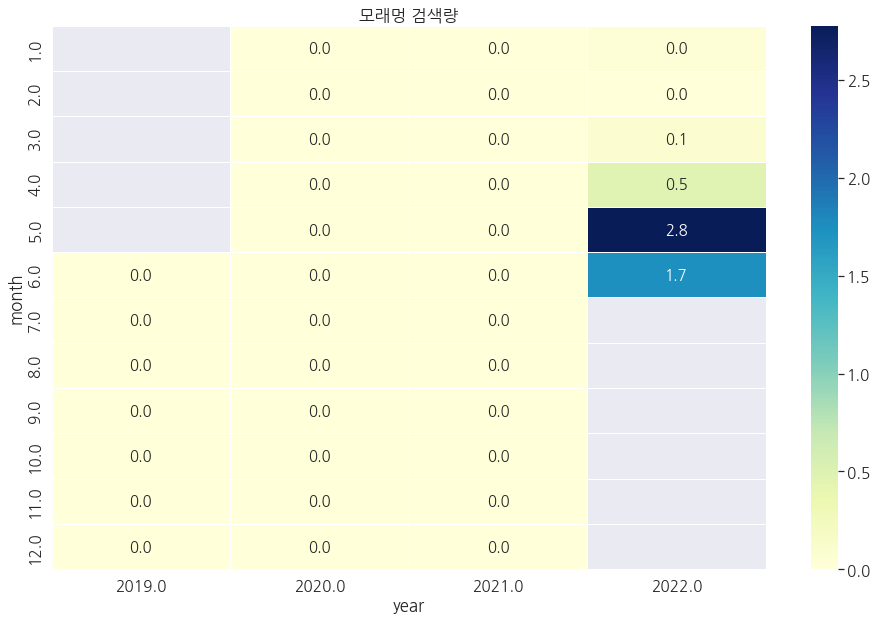

In [60]:
heatplot()

In [58]:
# heatplot_compare() ; 키워드 비교 열지도 시각화
def heatplot_compare():
    """
    '키워드1' vs '키워드2' 검색량을 비교해서 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])

    # keyword1, keyword2 = 조회할 키워드 입력
    keyword1 = input("검색량을 조회할 키워드1 입력 :")
    keyword2 = input("검색량을 조회할 키워드2 입력 :")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword1), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
    sns.heatmap(df_ym.pivot("month", "year", keyword2), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)
    ax1.set_title(keyword1 + " 검색량")
    ax2.set_title(keyword2 + " 검색량")
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + keyword1 + 'vs' + keyword2 + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
167  2022-06-11       침대옆협탁
166  2022-06-11     천연라텍스베개
165  2022-06-11     거실장2000
158  2022-06-10  아쿠아텍스4인용소파
154  2022-06-10       티비거실장
..          ...         ...
3    2022-05-12        옷서랍장
1    2022-05-12       마켓비옷장
5    2022-05-12         론체어
6    2022-05-12  슈퍼싱글매트리스추천
0    2022-05-12    욕실규조토발매트

[168 rows x 2 columns]
검색량을 조회할 키워드1 입력 :박구환
검색량을 조회할 키워드2 입력 :물수정


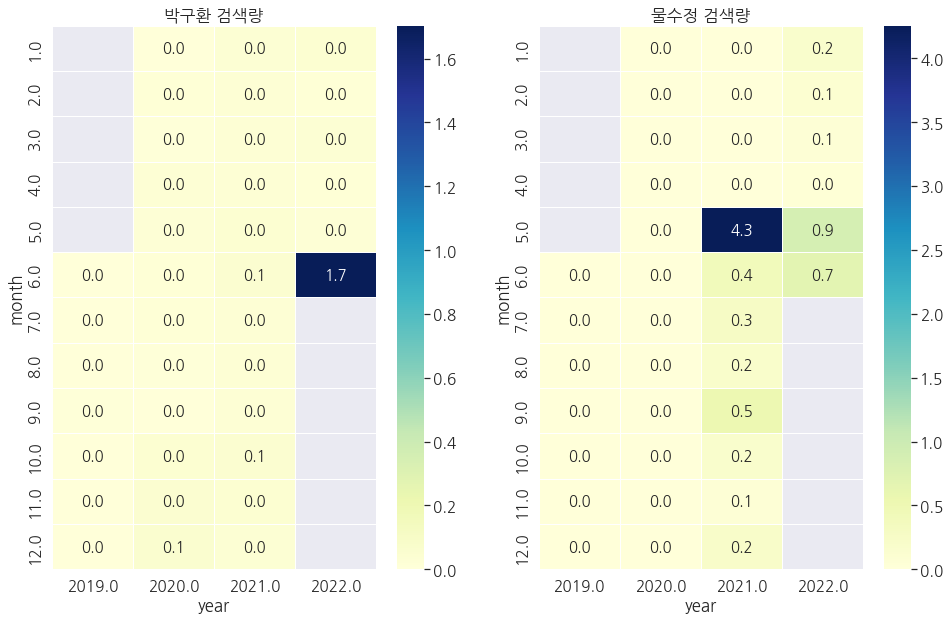

In [59]:
heatplot_compare()

# 키워드 네트워크 시각화용 자료 수집

In [74]:
# df_m = pd.read_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8', index_col=0)
# lis = list(df_m['키워드'])
lis

['욕실규조토발매트',
 '삼나무원목책상',
 '로렌책상',
 '마켓비옷장',
 '페이퍼인센스',
 '옷서랍장',
 '허리베개',
 '론체어',
 '슈퍼싱글매트리스추천',
 '실내용디퓨저byldf001천연디퓨저',
 '천연디퓨저실내용디퓨저byldf001',
 '헤링본여름쿨매트',
 '천연디퓨저디퓨저byldf001실내용',
 '실내용byldf001천연디퓨저디퓨저',
 '천연디퓨저디퓨저실내용byldf001',
 '실내용byldf001디퓨저천연디퓨저',
 '실내용천연디퓨저byldf001디퓨저',
 '쪽가위',
 '실내용천연디퓨저디퓨저byldf001',
 '마켓비원목선반',
 '소음재',
 '모래멍',
 '책상컴퓨터의자',
 '양면암막커튼',
 '학생책상의자',
 '메트로캔들워머',
 '릴리4인용세라믹식탁',
 '컴퓨터학생의자',
 '빨아쓰는발매트',
 '헬시메이트블랙라벨기능성메모리폼경추베개',
 '오에스퍼니처osg100컴퓨터게이밍의자',
 '원목4인식탁세트벤치+의자형',
 '장미맨숀',
 '전자렌지밥솥오븐수납장선반',
 '전자레인지밥솥오븐선반수납장600',
 '사무용책상의자',
 '실내용디퓨저',
 '실내용천연디퓨저',
 '무볼트앵글',
 '모던티비다이',
 '데코지오쉐도우아일렛형암막커튼일반커튼방한커튼가리개커튼',
 '편백깔판',
 '르올바디필로우',
 '실내분수',
 '우드행거',
 '원목침대프레임ss',
 '투에이치몰슈퍼싱글이불',
 '헤링본쿨매트',
 '시스템행거2단행거',
 '여름이불60수',
 '태양열조명',
 '컴피플러피60수순면피그먼트패드라지킹이스턴킹',
 '방수베개커버',
 '릴리즈철제캔들홀더촛불양초티라이트받침',
 '선인장소품홈데코귀여운인테리어장식소품w95683b',
 '아망뜨북유럽풍가죽식탁매트감성사각테이블매트',
 '아쿠아텍스3인용패브릭소파',
 '사무용컴퓨터의자블랙',
 '바퀴달린책상사이드테이블소파옆내추럴z형',
 '에르고휴먼',
 '아쿠아텍스패브릭2인',
 '더식스슈퍼싱글매트리스',
 '잠솔솔',
 '리빙제이',
 '발릴라',
 '화이트소프트매

In [75]:
# 

In [76]:
def related_word_parse(word_list, n): 
    """
    검색어의 연관검색어를 반복해서 검색하는 함수입니다.
    ...
    word_list = 검색할 키워드 값이 있는 리스트
    n = 검색어의 연관검색어를 거듭진행할 회차 수 (일단은 3번 위주로)
    """
    if n==0:
        print('작업 종료')
        
    else:
        merge_df = pd.DataFrame()
        for i in tqdm(range(len(word_list))):
            temp_df = pd.DataFrame()
            temp_list = []
            url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query=' + word_list[i]
            r = requests.get(url)
            soup_r = bs4.BeautifulSoup(r.text, 'lxml')
            print(word_list[i])
            result = soup_r.select('ul.lst_related_srch > li.item')
            time.sleep(1)
            
            
            try:
                result = soup_r.select('ul.lst_related_srch > li.item')
            
            
            # 연관검색어가 없는 키워드일 때 예외처리
            except:
                if pd.isna(result):
                    result = []
                
                    
            if len(result) == 0:
                pass
            
            else:
                for k in result:
                    temp_list.append(k.text.replace("  ",""))
                
                temp_df['sub_word'] = temp_list
                temp_df['sup_word'] = word_list[i]
                temp_df = pd.DataFrame(temp_df, columns=['sup_word', 'sub_word'])
                
                merge_df = pd.concat([merge_df, temp_df], axis=0)
                
        # 반복회차 결과 저장
        dictionary[n] = merge_df

        # 반복호출
        pass_word_list = merge_df['sub_word'].values

        print('==========다음 회차 시작')
        related_word_parse(pass_word_list, n-1)


In [77]:
dictionary = {}
len(lis)

322

In [78]:
related_word_parse(lis, 3)

  0%|          | 0/322 [00:00<?, ?it/s]

욕실규조토발매트
삼나무원목책상
로렌책상
마켓비옷장
페이퍼인센스
옷서랍장
허리베개
론체어
슈퍼싱글매트리스추천
실내용디퓨저byldf001천연디퓨저
천연디퓨저실내용디퓨저byldf001
헤링본여름쿨매트
천연디퓨저디퓨저byldf001실내용
실내용byldf001천연디퓨저디퓨저
천연디퓨저디퓨저실내용byldf001
실내용byldf001디퓨저천연디퓨저
실내용천연디퓨저byldf001디퓨저
쪽가위
실내용천연디퓨저디퓨저byldf001
마켓비원목선반
소음재
모래멍
책상컴퓨터의자
양면암막커튼
학생책상의자
메트로캔들워머
릴리4인용세라믹식탁
컴퓨터학생의자
빨아쓰는발매트
헬시메이트블랙라벨기능성메모리폼경추베개
오에스퍼니처osg100컴퓨터게이밍의자
원목4인식탁세트벤치+의자형
장미맨숀
전자렌지밥솥오븐수납장선반
전자레인지밥솥오븐선반수납장600
사무용책상의자
실내용디퓨저
실내용천연디퓨저
무볼트앵글
모던티비다이
데코지오쉐도우아일렛형암막커튼일반커튼방한커튼가리개커튼
편백깔판
르올바디필로우
실내분수
우드행거
원목침대프레임ss
투에이치몰슈퍼싱글이불
헤링본쿨매트
시스템행거2단행거
여름이불60수
태양열조명
컴피플러피60수순면피그먼트패드라지킹이스턴킹
방수베개커버
릴리즈철제캔들홀더촛불양초티라이트받침
선인장소품홈데코귀여운인테리어장식소품w95683b
아망뜨북유럽풍가죽식탁매트감성사각테이블매트
아쿠아텍스3인용패브릭소파
사무용컴퓨터의자블랙
바퀴달린책상사이드테이블소파옆내추럴z형
에르고휴먼
아쿠아텍스패브릭2인
더식스슈퍼싱글매트리스
잠솔솔
리빙제이
발릴라
화이트소프트매트리스
마켓비모듈수납장
메모리폼매트리스ss
스마일무소음해머벨탁상시계방긋인테리어시계
거실속커튼
거실쉬폰커튼
무지천
린즈홈
맞춤제작수납선반철제팬트리모듈다용도조립미니랙
조립식diy선반
매트리스깔판패밀리받침대
오가닉순면100줄누빔
코난범인무드등
프리미엄
경추베개스탠바이미
기능성
시디즈메쉬의자
휴레카편백나무메모리폼베개0066
트웸코
유지연작가한정판인테리어액자
평상형원목침대프레임ss
컴퓨터사무용의자
비정형거울
책상사무용의자
사무용의자모드니
골드에디션디퓨저200ml1+1
방수실

  0%|          | 0/555 [00:00<?, ?it/s]

마켓비 철제옷장
옷장
이케아 옷장
옵타움 페이퍼인센스
페이퍼인센스세트
페이퍼인센스홀더
인센스스틱
콜린스 인센스
종이인센스
우드인센스
원목 옷 서랍장
5단서랍장
3단 서랍장
화장대서랍장
플라스틱서랍장
미니서랍장
4단서랍장
와이드서랍장
2단서랍장
틈새 서랍장
수면허리베개
조은잠 허리베개
경추베개
메밀베개
일자목베개
다리베개
꼬북베개
역류성식도염 베개
거북목베개
발베개
론체어 클래식
론체어 로우백
론체어 컵홀더
론체어 하이백
슈프림 론체어
슈퍼싱글 매트리스
일제쪽가위
고급쪽가위
일본쪽가위
삼덕쪽가위
슬로우 모래멍
모래멍샌드아트
고등학생책상의자
편한책상의자
컴퓨터책상의자
빨아쓰는 규조토 발매트
발매트
무볼트앵글선반
무볼트 선반
높은 티비다이
철제티비다이
대리석티비다이
미니 티비다이
티비다이인테리어
낮은 티비다이
원목 티비다이 
심플티비다이
고급티비다이
티비다이 1800
실내 분수대
미니분수
태양광분수
가정용 분수
태양열 분수
연못분수
인테리어 분수
분수노즐
실내연못
실내 폭포
우드선반행거
우드 미니 행거
우드2단행거
우드벽걸이행거
시스템행거
이동식 행거
벽행거
옷걸이행거
원목행거
철제행거
태양열 캠핑조명
태양광 조명
태양열 가로등
테라스 조명
태양열 전구
태양열 전등
태양열 알전구
실외조명
태양열 led
태양열 벽부등
방수베개속커버
메모리폼베개방수커버
베개커버5070
베개커버4060
베개커버3050
라텍스베개커버
호텔베개커버
둥근베개커버
린넨베개커버
레자베개커버
에르고휴먼v2
에르고휴먼의자
잠솔솔 베개
리빙제이 잠솔솔
리빙제이 베개
리빙제이 잠솔솔
발릴라 매트리스
발릴라 제빵기
발릴라 몽제
발릴라 아이스크림
거실속커튼 인테리어
거실속커튼 커텐
거실속커튼 아파트
거실속커튼 암막
거실속커튼 분위기
거실 커튼
대전 현대프리미엄아웃렛
유튜브 프리미엄 우회
김치프리미엄
유튜브 프리미엄
유튜브 프리미엄 가격
호관원 프리미엄 가격
롯데시네마 프리미엄구미센트럴
프리미엄 고속버스
아로나민 골드 프리미엄
유튜브 프리미엄 해지
기능성 반팔
나이키 기능성 반팔
기능성 긴팔
기능성 반팔티


  0%|          | 0/3328 [00:00<?, ?it/s]

마켓비 철제수납장
마켓비 옷장
철제 옷장
슬라이딩 옷장
원룸 옷장
800 옷장
1200 옷장
오픈형 옷장
600 옷장
작은방 옷장
옷장 1000
화장대 옷장
자취방 옷장
이케아 슬라이딩 옷장
이케아 비키니옷장
이케아 옷장 조립
이케아 스투바 옷장
이케아 간이옷장
이케아 미닫이 옷장
이케아서랍옷장
이케아 거울옷장
이케아 원목옷장
이케아 코너옷장
옵타움 페이퍼 인센스 세트
hem 인센스스틱
인센스 스틱 홀더
인센스스틱 사용법
인센스스틱 부작용
인센스스틱 사용
인센스스틱 추천
인센스스틱 끄는법
인센스스틱 향
인센스스틱 강아지
인센스스틱 모기
콜린스 인센스 향
콜린스 인센스 스틱
콜린스 올인원 인센스
인센스
인센스 스틱
콜린스
인센스스틱
페이퍼인센스
옵타움 인센스
인센스 우드
원목5단서랍장
5단서랍장800
5단서랍장900
5단 서랍장 1000
플라스틱5단서랍장
5단서랍장400
엔틱5단서랍장
5단 와이드 서랍장
라탄5단서랍장
5단서랍장600
화이트3단서랍장
3단서랍장800
3단서랍장1200
3단와이드서랍장
3단서랍장600
원목 3단 서랍장
플라스틱3단서랍장
3단서랍장400
철제3단서랍장
3단 미니 서랍장
5단서랍장
3단 서랍장
플라스틱서랍장
원목 서랍장
미니서랍장
4단서랍장
와이드서랍장
2단서랍장
옷 서랍장
엔틱서랍장
플라스틱4단서랍장
5단서랍장
3단 서랍장
화장대서랍장
원목 서랍장
미니서랍장
와이드서랍장
플라스틱 수납장
2단서랍장
옷 서랍장
원목미니서랍장
1단미니서랍장
4단미니서랍장
우드미니서랍장
5단서랍장
3단 서랍장
화장대서랍장
플라스틱서랍장
2단서랍장
옷 서랍장
4단 서랍장 800
원목4단서랍장
4단와이드서랍장
플라스틱4단서랍장
4단 서랍장 600
4단서랍장500
4단서랍장1000
4단미니서랍장
4단책상서랍장
4단서랍장400
원목와이드서랍장
3단와이드서랍장
5단 와이드 서랍장
2단와이드서랍장
4단와이드서랍장
6단와이드서랍장
빅와이드서랍장
엔틱와이드서랍장
라탄와이드서랍장
와이드서랍장1500
2단와이드서랍장
원목2단서랍장
플라스틱 2단서랍장
2단미니서랍장
2단 서랍

보비트롤리 34
몰룸 보비트롤리
이케아 트롤리
마켓비 트롤리
한샘 트롤리
비라인 트롤리
모던하우스 트롤리
원목 트롤리
접이식 트롤리
usm 트롤리
마켓비 원목트롤리
이케아 트롤리
한샘 트롤리
모던하우스 트롤리
주방 트롤리
접이식 트롤리
2단 트롤리
우드 트롤리
5단 트롤리
빈티지 트롤리
한샘 모리 트롤리
한샘 재크 트롤리
한샘 3단 트롤리
한샘 재크플러스 트롤리
이케아 트롤리
보비트롤리
마켓비 트롤리
비라인 트롤리
모던하우스 트롤리
주방 트롤리
이케아 트롤리
보비트롤리
마켓비 트롤리
한샘 트롤리
모던하우스 트롤리
주방 트롤리
원목 트롤리
접이식 트롤리
2단 트롤리
usm 트롤리
모던하우스 3단 트롤리
이케아 트롤리
보비트롤리
마켓비 트롤리
한샘 트롤리
주방 트롤리
원목 트롤리
접이식 트롤리
2단 트롤리
마지스트롤리
원목이동식 트롤리
원목3단트롤리
이케아 트롤리
보비트롤리
마켓비 트롤리
한샘 트롤리
모던하우스 트롤리
주방 트롤리
접이식 트롤리
2단 트롤리
접이식3단트롤리
이케아 트롤리
보비트롤리
마켓비 트롤리
모던하우스 트롤리
주방 트롤리
원목 트롤리
2단 트롤리
페자니 트롤리
마지스트롤리
회전서랍트롤리
이동식 서랍 트롤리
이케아 트롤리
보비트롤리
마켓비 트롤리
한샘 트롤리
3단 트롤리
틈새 트롤리
주방 트롤리
원목 트롤리
본베베 침대가드
노인침대안전가드
bbz 침대가드
원목침대가드
어린이침대가드
침대 사이드가드
접이식침대가드
침대보호가드
매트리스 안전가드
침대 낙상방지
침대 안전바
baby bbz 침대가드
본베베 침대가드
침대 가드
한샘 침대가드
한샘 샘키즈 침대 가드
baby bbz
쿠시노 bbz
침대 안전가드
어린이침대가드
침대 사이드가드
침대보호가드
원목 안전가드
높은 침대 가드
침대 안전가드
bbz 침대가드
침대가드쿠션
원목침대가드
어린이침대가드
유아침대쿠션
유아침대프레임
본베베 침대가드
한샘 침대프레임
bbz 침대가드
한샘 아임빅 침대
원목침대가드
어린이침대가드
한샘 안전가드
한샘 침대헤드
본베베 침대가드 쿠시노
일룸 쿠시노침대 가드
침대가드쿠션
일룸

유치원 친구 생일선물
5살 유치원 생일선물
7살 유치원 생일선물
5세 유치원 생일선물
유치원 생일선물 답례품
어린이집 생일선물
유치원 생일 답례품
애로부부 영어유치원
애로부부 가야금
애로부부 93회
애로부부 맘카페
애로부부 93
영어유치원 답례품
유치원 간식답례품
유치원양말답례품
병설유치원 방학
병설유치원 대기
병설유치원 방과후
병설유치원 스승의날
병설유치원 방과후교사
병설유치원 비용
병설유치원 임용고시
병설유치원 여름방학
병설유치원 하원시간
병설유치원 스승의날 선물
사무실 파티션 꾸미기
사무실이동식파티션
책상 파티션
유리파티션
사무실가구
사무실 가림막
사무용파티션
사무실칸막이
아크릴 파티션
간이 파티션
책상위파티션
책상타공파티션
책상 철제 파티션
책상 파티션 타공판
사무실파티션
책상 가림막
책상 칸막이
책상 가림판
사무용파티션
아크릴 파티션
강화유리파티션
사무실 유리 파티션
불투명 유리 파티션
책상 파티션
유리칸막이
아크릴 파티션
방음 파티션
디자인 파티션
슬라이딩 파티션
투명파티션
간이 칸막이
책상 스크린 파티션
사무실파티션
강화유리파티션
사무용파티션
아크릴 파티션
방음 파티션
간이 파티션
투명파티션
책상위파티션
플랫파티션
린넨롱원피스
린넨셔츠원피스
린넨나시원피스
린넨체크원피스
린넨 미니원피스
린넨반팔원피스
린넨 끈 원피스
브이넥린넨원피스
하객원피스
쉬폰 원피스
린넨반팔자켓
린넨크롭자켓
노카라 린넨자켓
린넨 숏자켓
린넨자켓 코디
오버핏 린넨자켓
린넨체크자켓
린넨롱자켓
화이트 린넨자켓
린넨자켓세트
타미 린넨셔츠
오버핏 린넨셔츠
린넨롱셔츠
린넨셔츠 코디
린넨 반팔 셔츠
린넨 스트라이프 셔츠
린넨 크롭 셔츠
린넨체크셔츠
네이비 린넨셔츠
린넨7부셔츠
타미 린넨셔츠
오버핏 린넨셔츠
린넨 반팔 셔츠
린넨 스트라이프 셔츠
린넨긴팔셔츠
uspa린넨셔츠
린넨차이나셔츠
헨리넥 린넨셔츠
카페 린넨
린넨타올
바리스타 타올
린넨마바지
마 린넨
린넨마자켓
린넨마셔츠
린넨과 마
린넨
마
린넨바지
린넨천
마 세탁
린넨천
린넨 마
린넨
린넨 치마바지
린넨바지 코디
린넨마바지
린넨일자바지

3단 접이식 매트
접이식 매트리스 추천
3단 접이식 매트리스
3단접이식매트
3단 접이식 라텍스
3단 접이식 메모리폼
75인치 티비 사이즈
티비 거실장
높은 티비다이
모던티비다이
철제티비다이
대리석티비다이
미니 티비다이
원룸 티비다이
낮은 티비다이
안방티비다이
티비다이1200
원목 티비다이 
룸앤티비 거치대
이젤형 티비거치대
75인치 티비 거치대
티비 이젤 거치대
캠핑티비거치대
낮은티비거치대
크롬티비거치대
티비거치대 바퀴
대우티비거치대
높이조절티비거치대
북유럽원목거실장
원목 높은 거실장
원목거실장세트
원목낮은거실장
오크원목거실장
엔틱원목거실장
원목템바보드거실장
원목거실장 2400
고무나무원목 거실장
원목거실장 1200
월넛6인용식탁
월넛6인식탁
월넛4인식탁
월넛원목식탁
북미산월넛식탁
세라믹식탁
포세린 식탁
엔틱식탁
호두나무 식탁
저상형 식탁
6인용식탁
원목식탁
세라믹식탁
포세린 식탁
대리석식탁
엔틱식탁
월넛 식탁
통세라믹 식탁
4인 식탁세트
고무나무식탁
원목거실테이블
세라믹 거실테이블
높은 거실테이블
거실 탁자 테이블
원형쇼파테이블
거실 좌식테이블
원형거실테이블
거실 유리테이블
기능성거실테이블
거실테이블인테리어
원목원형거실테이블
거실 쇼파테이블
원목 좌식테이블
원목 접이식 테이블
거실 공부테이블
세라믹 거실테이블
높은 거실테이블
거실 탁자 테이블
기능성거실테이블
거실테이블인테리어
거실 쇼파테이블
원목거실테이블
높은 소파테이블
거실접이식테이블
거실 공부테이블
세라믹 거실테이블
거실 탁자 테이블
원형거실테이블
기능성거실테이블
높은원목테이블
원목거실테이블
강화유리 테이블
원형거실테이블
대리석거실테이블
투명거실테이블
화이트 거실테이블
디자인 거실테이블
거실 쇼파테이블
원목거실테이블
세라믹 거실테이블
거실 좌식테이블
대리석원형테이블
천연대리석테이블
엔틱거실테이블
템바보드 거실테이블
대리석 소파 테이블
대리석 좌식테이블
세라믹 테이블
타원형 테이블
세라믹원형소파테이블
세라믹 거실테이블
원목 소파테이블
접이식 소파테이블
세라믹 좌식테이블
모듈 소파테이블
대리석 소파 테이블


In [79]:
# 파싱 결과 병합 작업

In [80]:
dictionary[3]

,sup_word,sub_word
0,마켓비옷장,마켓비 철제옷장
1,마켓비옷장,옷장
2,마켓비옷장,이케아 옷장
0,페이퍼인센스,옵타움 페이퍼인센스
1,페이퍼인센스,페이퍼인센스세트
...,...,...
2,침대옆협탁,원목침대협탁
3,침대옆협탁,엔틱침대협탁
4,침대옆협탁,침대옆서랍장
5,침대옆협탁,침대 옆 서랍


In [124]:
dictionary[3]

,sup_word,sub_word
8,황금,황금코다리
0,황금,황금 약재
9,황금,bbq 황금올리브
7,황금,부대찌개 황금레시피
6,황금,황금사자기
5,황금,잡채 황금레시피
4,황금,떡볶이 황금레시피
2,황금,황금효능
1,황금,한약재 황금
3,황금,황금약초


In [81]:
dictionary[2]

,sup_word,sub_word
0,마켓비 철제옷장,마켓비 철제수납장
1,마켓비 철제옷장,마켓비 옷장
2,마켓비 철제옷장,철제 옷장
0,옷장,슬라이딩 옷장
1,옷장,원룸 옷장
...,...,...
3,원목침대협탁,원목미니협탁
4,원목침대협탁,원목 2단협탁
5,원목침대협탁,라탄침대협탁
6,원목침대협탁,침대협탁화이트


In [82]:
dictionary[1]

,sup_word,sub_word
0,마켓비 철제수납장,이케아 철제 수납장
1,마켓비 철제수납장,마켓비 캐비넷
2,마켓비 철제수납장,마켓비 모듈
3,마켓비 철제수납장,한샘 철제수납장
4,마켓비 철제수납장,3단철제수납장
...,...,...
0,침대미니협탁,침대 옆 협탁
1,침대미니협탁,원목침대협탁
2,침대미니협탁,침대틈새협탁
3,침대미니협탁,원목미니협탁


In [83]:
merge1 = pd.merge(dictionary[3], dictionary[2], left_on='sub_word', right_on='sup_word')
merge2 = pd.merge(dictionary[2], dictionary[1], left_on='sub_word', right_on='sup_word')
merge2

,sup_word_x,sub_word_x,sup_word_y,sub_word_y
0,마켓비 철제옷장,마켓비 철제수납장,마켓비 철제수납장,이케아 철제 수납장
1,마켓비 철제옷장,마켓비 철제수납장,마켓비 철제수납장,마켓비 캐비넷
2,마켓비 철제옷장,마켓비 철제수납장,마켓비 철제수납장,마켓비 모듈
3,마켓비 철제옷장,마켓비 철제수납장,마켓비 철제수납장,한샘 철제수납장
4,마켓비 철제옷장,마켓비 철제수납장,마켓비 철제수납장,3단철제수납장
...,...,...,...,...
58300,원목침대협탁,침대미니협탁,침대미니협탁,침대 옆 협탁
58301,원목침대협탁,침대미니협탁,침대미니협탁,원목침대협탁
58302,원목침대협탁,침대미니협탁,침대미니협탁,침대틈새협탁
58303,원목침대협탁,침대미니협탁,침대미니협탁,원목미니협탁


In [84]:
merge1 = merge1.drop(['sub_word_x'], axis=1)
merge1.columns = ['sup_word', 'sub_word1','sub_word2']
merge1

,sup_word,sub_word1,sub_word2
0,마켓비옷장,마켓비 철제옷장,마켓비 철제수납장
1,마켓비옷장,마켓비 철제옷장,마켓비 옷장
2,마켓비옷장,마켓비 철제옷장,철제 옷장
3,마켓비옷장,옷장,슬라이딩 옷장
4,마켓비옷장,옷장,원룸 옷장
...,...,...,...
3507,침대옆협탁,원목침대협탁,원목미니협탁
3508,침대옆협탁,원목침대협탁,원목 2단협탁
3509,침대옆협탁,원목침대협탁,라탄침대협탁
3510,침대옆협탁,원목침대협탁,침대협탁화이트


In [85]:
merge2 = merge2.drop(['sup_word_x', 'sub_word_x'], axis=1)
merge2.columns = ['drop', 'sub_word3']
merge2

,drop,sub_word3
0,마켓비 철제수납장,이케아 철제 수납장
1,마켓비 철제수납장,마켓비 캐비넷
2,마켓비 철제수납장,마켓비 모듈
3,마켓비 철제수납장,한샘 철제수납장
4,마켓비 철제수납장,3단철제수납장
...,...,...
58300,침대미니협탁,침대 옆 협탁
58301,침대미니협탁,원목침대협탁
58302,침대미니협탁,침대틈새협탁
58303,침대미니협탁,원목미니협탁


In [87]:
# 작업결과 저장
total_words = pd.merge(merge1, merge2, left_on='sub_word2', right_on='drop')
total_words = total_words.drop(['drop'], axis=1)
total_words.to_csv('C:/project/CODE/keyword/data/furniture/network/' + yeserday + 'multiple_related_word_parse.csv', encoding='utf-8')
total_words

NameError: name 'yeserday' is not defined

## 여기서부터는 키워드 네트워크 시각화

#### 일단은 키워드 1개만으로 작업

In [93]:
##### 여기서부터는 임시 작업용 df 호출 #####
# total_words = pd.read_csv('C:/project/CODE/keyword/data/furniture/network/multiple_related_word_parse.csv', encoding='utf-8', index_col=0)
uniq_word = total_words.drop_duplicates(['sup_word'], keep='first')
uniq_wordlist = list(uniq_word['sup_word'])
uniq_wordlist

['마켓비옷장',
 '페이퍼인센스',
 '옷서랍장',
 '에몬스',
 '허리베개',
 '방수베개커버',
 '론체어',
 '슈퍼싱글매트리스추천',
 '이불토퍼',
 '발릴라',
 '학생책상의자',
 '마켓비책상',
 '빨아쓰는발매트',
 '무볼트앵글',
 '모던티비다이',
 '거실장2000',
 '티비거실장',
 '실내분수',
 '우드행거',
 '스피드랙행거',
 '태양열조명',
 '에르고휴먼',
 '잠솔솔',
 '리빙제이',
 '거실쉬폰커튼',
 '암막커튼추천',
 '프리미엄',
 '기능성',
 '시디즈메쉬의자',
 '트웸코',
 '비정형거울',
 '셀레티거울',
 '알레르망냉감패드',
 '시어서커',
 '린넨',
 '박술녀풍기인견이불',
 '아로마버너',
 '방음재',
 '마지스트롤리',
 '본베베침대가드',
 '침대슈퍼싱글',
 '캥거루앞치마',
 '침대커튼',
 '스타벅스테이블',
 '대리석소파테이블',
 '대리석거실테이블',
 '세라믹거실테이블',
 '초마루디퓨저',
 '메탈시트지',
 '한옥',
 '황금',
 '지컷원피스',
 '인조',
 '식탁세라믹',
 '유치원',
 '사무용파티션',
 '덴마크화병',
 '밥솥선반',
 '실리콘네온사인',
 '소파3인용',
 '쇼파3인',
 '식탁6인용',
 '식탁4인용',
 '고무나무식탁',
 '침대프레임원목',
 '침대프레임퀸',
 '도토리수납함',
 '네이즌쿨매트',
 '패브릭스툴',
 '모찌',
 '접이식토퍼매트리스',
 '천연라텍스베개',
 '침대옆협탁']

In [111]:
def create_nx_df():
    """
    키워드 연관도를 조회하기 위해 필터링된 데이터프레임을 만드는 함수입니다.
    ...
    """
    global df_sup
    keyword = input("연관도를 조회할 키워드를 입력하세요: ")
    df_sup = total_words[total_words['sup_word'] == keyword]
    df_sup
    return(df_sup)

In [96]:
# create_nx_df()

In [116]:
## 조회를 원하는 키워드 명을 input 으로 받는 형태가 나을까나 ~?~?
def create_nx():
    """
    트렌드 키워드의 연관검색어들 
    """
    # 라이브러리
    import networkx as nx
    import matplotlib.font_manager as fm ; from matplotlib import rc
    # 폰트 설정
    font_name = fm.FontProperties(fname="c:/Windows/Fonts/HMKMMAG.ttf").get_name()
    
    print("조회가능힌 키워드 목록입니다.")
    print("=" * 50)
    print(uniq_wordlist)
    print("=" * 50)
    
    create_nx_df()

    # 네트워크 생성
    G = nx.Graph()
    
    for sup in list(set(df_sup['sup_word'].values)):
        G.add_node(sup)
        temp_df1 = df_sup[df_sup['sup_word']==sup]
        for sub1 in list(set(temp_df1['sub_word1'].values)):
            G.add_node(sub1)
            G.add_edge(sup,sub1)
            temp_df2 = temp_df1[temp_df1['sub_word1']==sub1]
            for sub2 in list(set(temp_df2['sub_word2'].values)):
                G.add_node(sub2)
                G.add_edge(sub1,sub2)
                temp_df3 = temp_df2[temp_df2['sub_word2']==sub2]
                for sub3 in list(set(temp_df3['sub_word3'].values)):
                    G.add_node(sub3)
                    G.add_edge(sub2,sub3)
                    
    title = list(df_sup['sup_word'])[0]
    color_map = []
    for node in G:
        if node == title:
            color_map.append('red')
        elif node in list(set(df_sup['sub_word1'].values)):
            color_map.append('orange')
        elif node in list(set(df_sup['sub_word2'].values)):
            color_map.append('yellow')
        else:
            color_map.append('violet')
            
    # 그래프 생성
    plt.figure(figsize=(30, 30))
    d = dict(G.degree)
    nx.draw(G,nodelist=d.keys(), node_size=[v * 1000 for v in d.values()], font_family=font_name,font_size=30, node_color = color_map, with_labels = True)
    # 한글 폰트에러 때문에 별도의 폰트 설정이 필요합니다.
    plt.axis('off')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + title + 'networkx_pic.png')
    plt.title(title + '연관어 관계도', fontsize=50)
    plt.show()
        

In [117]:
df_sup

,sup_word,sub_word1,sub_word2,sub_word3
218876,실리콘네온사인,네온사인 주문제작,네온사인 만들기,네온사인 주문제작
218877,실리콘네온사인,네온사인 주문제작,네온사인 만들기,실리콘네온사인
218878,실리콘네온사인,네온사인 주문제작,네온사인 만들기,네온사인 간판
218879,실리콘네온사인,네온사인 주문제작,네온사인 만들기,무드등 만들기
218880,실리콘네온사인,네온사인 주문제작,네온사인 만들기,네온사인 도안
...,...,...,...,...
219176,실리콘네온사인,아크릴네온사인,실리콘 네온사인,네온사인 주문제작
219177,실리콘네온사인,아크릴네온사인,실리콘 네온사인,네온사인 만들기
219178,실리콘네온사인,아크릴네온사인,실리콘 네온사인,led네온사인
219179,실리콘네온사인,아크릴네온사인,실리콘 네온사인,실리콘조명


조회가능힌 키워드 목록입니다.
['마켓비옷장', '페이퍼인센스', '옷서랍장', '에몬스', '허리베개', '방수베개커버', '론체어', '슈퍼싱글매트리스추천', '이불토퍼', '발릴라', '학생책상의자', '마켓비책상', '빨아쓰는발매트', '무볼트앵글', '모던티비다이', '거실장2000', '티비거실장', '실내분수', '우드행거', '스피드랙행거', '태양열조명', '에르고휴먼', '잠솔솔', '리빙제이', '거실쉬폰커튼', '암막커튼추천', '프리미엄', '기능성', '시디즈메쉬의자', '트웸코', '비정형거울', '셀레티거울', '알레르망냉감패드', '시어서커', '린넨', '박술녀풍기인견이불', '아로마버너', '방음재', '마지스트롤리', '본베베침대가드', '침대슈퍼싱글', '캥거루앞치마', '침대커튼', '스타벅스테이블', '대리석소파테이블', '대리석거실테이블', '세라믹거실테이블', '초마루디퓨저', '메탈시트지', '한옥', '황금', '지컷원피스', '인조', '식탁세라믹', '유치원', '사무용파티션', '덴마크화병', '밥솥선반', '실리콘네온사인', '소파3인용', '쇼파3인', '식탁6인용', '식탁4인용', '고무나무식탁', '침대프레임원목', '침대프레임퀸', '도토리수납함', '네이즌쿨매트', '패브릭스툴', '모찌', '접이식토퍼매트리스', '천연라텍스베개', '침대옆협탁']
연관도를 조회할 키워드를 입력하세요: 페이퍼인센스


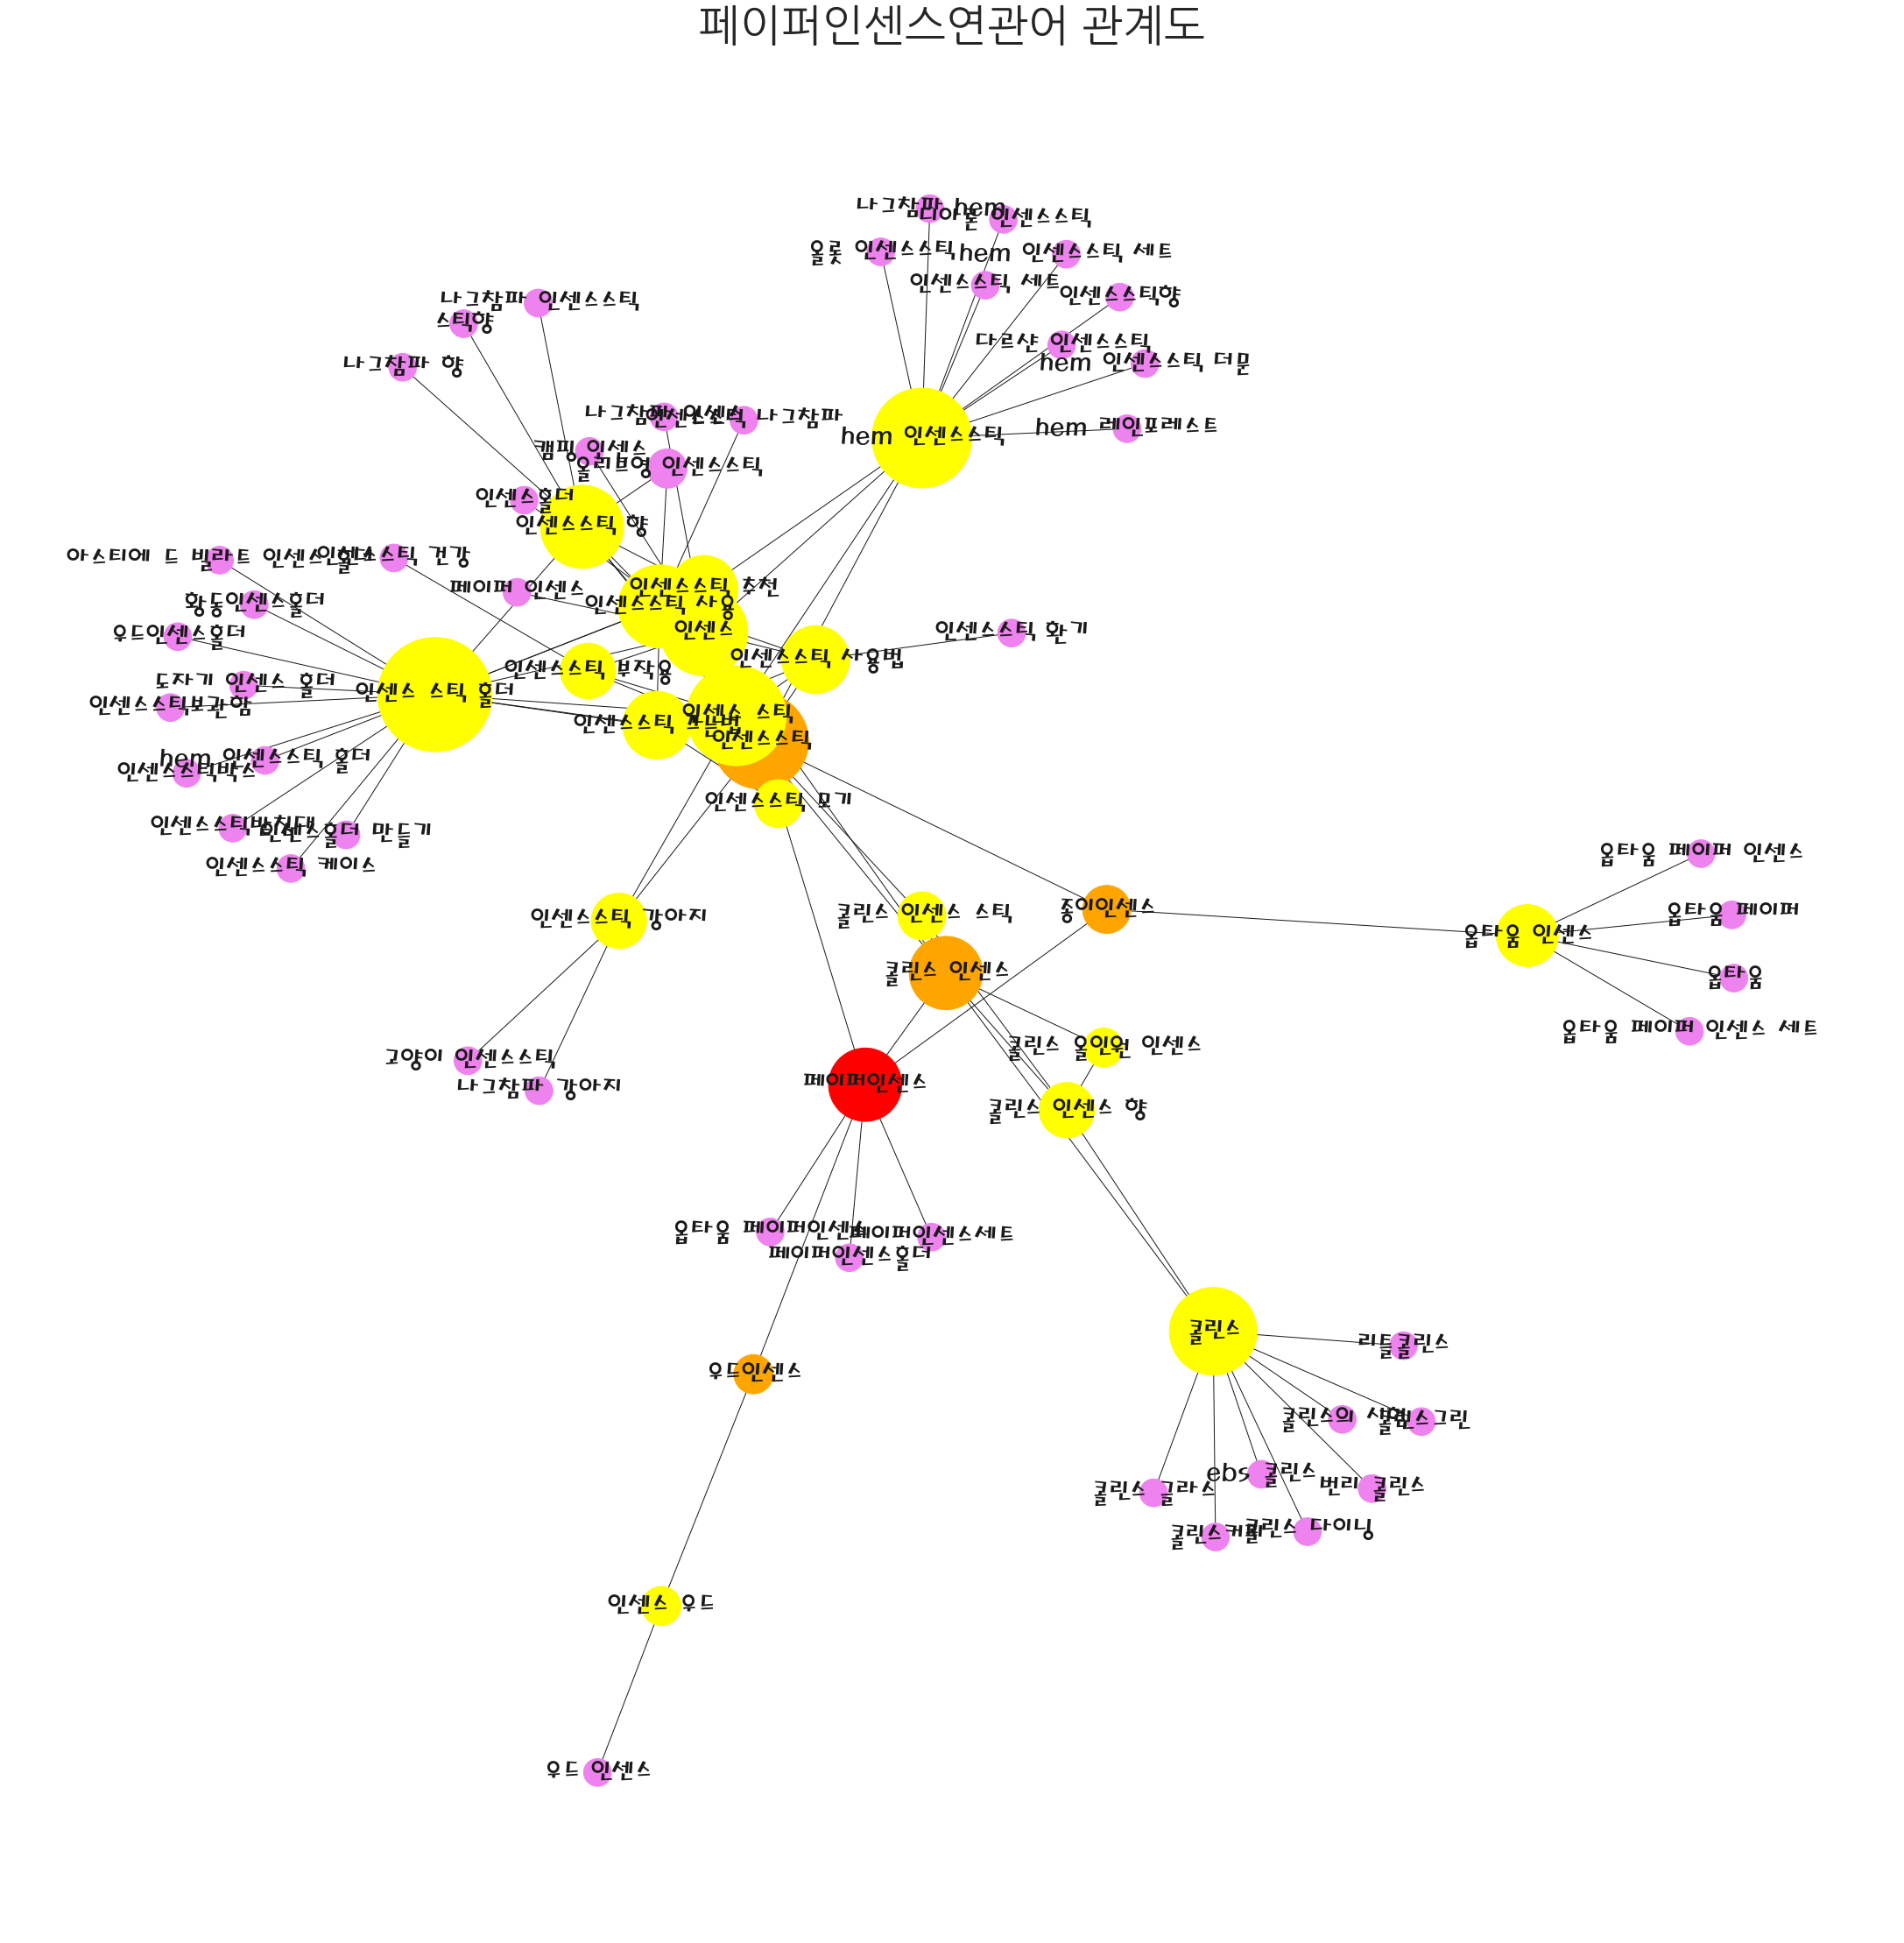

In [122]:
create_nx()

In [121]:
df_m.sort_values('월간검색량', ascending=False).head(20)

,등장일자,랭킹,키워드,일간검색량,월간검색량
17,2022-05-14,260,장미맨숀,32465,238286
102,2022-05-31,16,지컷원피스,1582,51973
108,2022-06-01,236,린넨,1705,49762
129,2022-06-04,496,화사거울,13190,38544
104,2022-05-31,298,에몬스,1178,32785
60,2022-05-23,431,시어서커,1044,29405
105,2022-05-31,363,유치원,1048,27776
5,2022-05-12,441,론체어,758,20975
45,2022-05-20,403,프리미엄,1045,20825
103,2022-05-31,177,인조,717,19167


# 키워드 형태소분석 도전

In [131]:
# 라이브러리
import konlpy
import pickle

from konlpy.tag import Okt ; okt = Okt()
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [132]:
# from konlpy.tag import Okt
# okt 예시
# okt = Okt()
# print(okt.nouns(read_keywords)) # nouns = 명사

In [125]:
# df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8', index_col=0)
df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/furniture/network/2022-06-11_multiple_related_word_parse.csv', encoding='UTF-8', index_col=0)
# write_keywords = list(df_konlpy[0])
# write_keywords

In [141]:
def create_wc_df():
    global df_wc
    """
    특정 키워드와 해당 키워드의 다중 연관검색어들을 워드클라우드로 시각화 하는 함수입니다.
    ...
    """
    print("조회가능힌 키워드 목록입니다.")
    print("=" * 50)
    print(uniq_wordlist)
    print("=" * 50)
    
    keyword = input("워드 클라우드를 조회할 키워드를 입력하세요: ")
    
    
    # 워드클라우드를 조회하기 위해 특정 키워드로 필터링된 데이터프레임 생성
    df_sup = df_konlpy[df_konlpy['sup_word'] == keyword]
    sup_word = list(df_konlpy.iloc[:,0])
    sub_word1 = list(df_konlpy.iloc[:,1])
    sub_word2 = list(df_konlpy.iloc[:,2])
    sub_word3 = list(df_konlpy.iloc[:,3])
    df_wc = sup_word + sub_word1 + sub_word2 + sub_word3
    
    return(df_wc)

In [ ]:
create_wc_df()


#제목 및 본문 txt에 저장
text = open('trash.txt','w',encoding='UTF-8')
for i in df_wc:
    text.write(i)
    text.write(" ") # 띄어쓰기 구분
text.close()

# text 파일 읽어오기
text = open('trash.txt','rt', encoding='UTF-8').read()
# print("블로그 텍스트 내용: " + blog_text)

# Okt 함수를 이용해 형태소 분석
okt = Okt()
line =[]

line = okt.pos(text)

n_adj =[]
# 명사 또는 형용사인 단어만 n_adj에 넣어주기
for word, tag in line:
    if tag in ['Noun']:
        n_adj.append(word)

# print(n_adj)

# 불용어 사전
f = open("C:/project/CODE/keyword/data/stopwords/stopwords_korean.txt", "rt", encoding="utf-8")
lines = f.readlines()
stop_words = []
for line in lines:
    line = line.replace('\n', '') #txt 읽을 때 \n 제거
    stop_words.append(line)
f.close()
# stop_words

n_adj = [word for word in n_adj if not word in stop_words]

# print(line)
# print(n_adj)

remove_one_word = [x for x in n_adj if len(x)>1 or x=='핏' or x=='청' or x=='롱' or x=='티']


#가장 많이 나온 단어 n개 저장
counts = Counter(n_adj)
tags = counts.most_common(50) # 저장 개수 지정 ; 내림차순



# 이미지 추가(워드 클라우드 모양 설정)

mask = Image.new("RGBA",(1500,1500), (255,255,255)) #(2500,2500) = 이미지 크기, (255,255,255) = RGB
image = Image.open('C:/project/img/square.png').convert("RGBA")
x,y = image.size
mask.paste(image,(0,0,x,y),image)
mask = np.array(mask)

### 워드 클라우드 생성 ###
#폰트지정
# sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
font='C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/MALGUN.ttf'
word_cloud = WordCloud(font_path=font, background_color='black',max_font_size=400, mask=mask,colormap='prism').generate_from_frequencies(dict(tags))


# 사이즈 설정 및 화면에 출력
plt.figure(figsize=(24,24))
plt.imshow(word_cloud)
plt.axis('off')
#워드클라우드 사진으로 저장
#cloud.to_file('네이버_키워드_블로그_워드클라우드.png')
#또는
plt.savefig('C:/project/CODE/keyword/data/furniture/wordcloud/' + yesterday + 'wordcloud.png', bbox_inches='tight')
plt.show()



조회가능힌 키워드 목록입니다.
['마켓비옷장', '페이퍼인센스', '옷서랍장', '에몬스', '허리베개', '방수베개커버', '론체어', '슈퍼싱글매트리스추천', '이불토퍼', '발릴라', '학생책상의자', '마켓비책상', '빨아쓰는발매트', '무볼트앵글', '모던티비다이', '거실장2000', '티비거실장', '실내분수', '우드행거', '스피드랙행거', '태양열조명', '에르고휴먼', '잠솔솔', '리빙제이', '거실쉬폰커튼', '암막커튼추천', '프리미엄', '기능성', '시디즈메쉬의자', '트웸코', '비정형거울', '셀레티거울', '알레르망냉감패드', '시어서커', '린넨', '박술녀풍기인견이불', '아로마버너', '방음재', '마지스트롤리', '본베베침대가드', '침대슈퍼싱글', '캥거루앞치마', '침대커튼', '스타벅스테이블', '대리석소파테이블', '대리석거실테이블', '세라믹거실테이블', '초마루디퓨저', '메탈시트지', '한옥', '황금', '지컷원피스', '인조', '식탁세라믹', '유치원', '사무용파티션', '덴마크화병', '밥솥선반', '실리콘네온사인', '소파3인용', '쇼파3인', '식탁6인용', '식탁4인용', '고무나무식탁', '침대프레임원목', '침대프레임퀸', '도토리수납함', '네이즌쿨매트', '패브릭스툴', '모찌', '접이식토퍼매트리스', '천연라텍스베개', '침대옆협탁']
워드 클라우드를 조회할 키워드를 입력하세요: 실리콘네온사인


In [198]:
# 자동 띄어쓰기 모듈
from pykospacing import Spacing

In [199]:
spacing = Spacing()

In [200]:
for item in write_keywords:
    kospacing_item = spacing(item)
    print(kospacing_item)

1/1 [==============================] - 1s 537ms/step
교련복
1/1 [==============================] - 0s 24ms/step
마르조 썸머 인 견 팬츠
1/1 [==============================] - 0s 23ms/step
반팔크롭자켓
1/1 [==============================] - 0s 25ms/step
세루티 자켓
1/1 [==============================] - 0s 26ms/step
올리비아로 렌티셔츠
1/1 [==============================] - 0s 27ms/step
비비안 마이핏 네모 팬티
1/1 [==============================] - 0s 23ms/step
안나수 이 원피스
1/1 [==============================] - 0s 23ms/step
나이스
1/1 [==============================] - 0s 26ms/step
행텐 10320-150-404-51
1/1 [==============================] - 0s 22ms/step
리린
1/1 [==============================] - 0s 23ms/step
법복
1/1 [==============================] - 0s 27ms/step
모르간 썸머 원피스
1/1 [==============================] - 0s 26ms/step
한지민 가디건
1/1 [==============================] - 0s 23ms/step
스프리스 기능성 바람막이
1/1 [==============================] - 0s 23ms/step
에바큐브
1/1 [==============================] - 0s 32ms/step
여성 정장 하객룩
1/1 [=================

# 트리박스 시각화...출하??

In [103]:
# shapes
"""
1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드들의 최근 1개월간 평균 검색량을 추출한 데이터프레임입니다.
"""
shapes = df_vis.copy()
shapes = shapes.truncate(before=time_month)
shapes = shapes.mean()
shapes = shapes.reset_index()
shapes.columns = ['keyword', 'month_avg_query']
shapes = shapes[:-2]
shapes = shapes.sort_values('month_avg_query', ascending=False).reset_index(drop=True)
shapes.head(20)

C:\Users\User\AppData\Local\Temp\ipykernel_20456\3092077136.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  shapes = shapes.mean()


,keyword,month_avg_query
0,리린,28.500079
1,김건희옷,15.449799
2,나이스,13.570576
3,운동화,13.052885
4,유니클로마르니,8.887810
5,마드제이,2.224100
6,디키즈874여자,1.889672
7,교련복,1.583467
8,폴로반팔셔츠,1.495555
9,셀린느티셔츠,1.452009


<AxesSubplot:title={'center':'최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드'}>

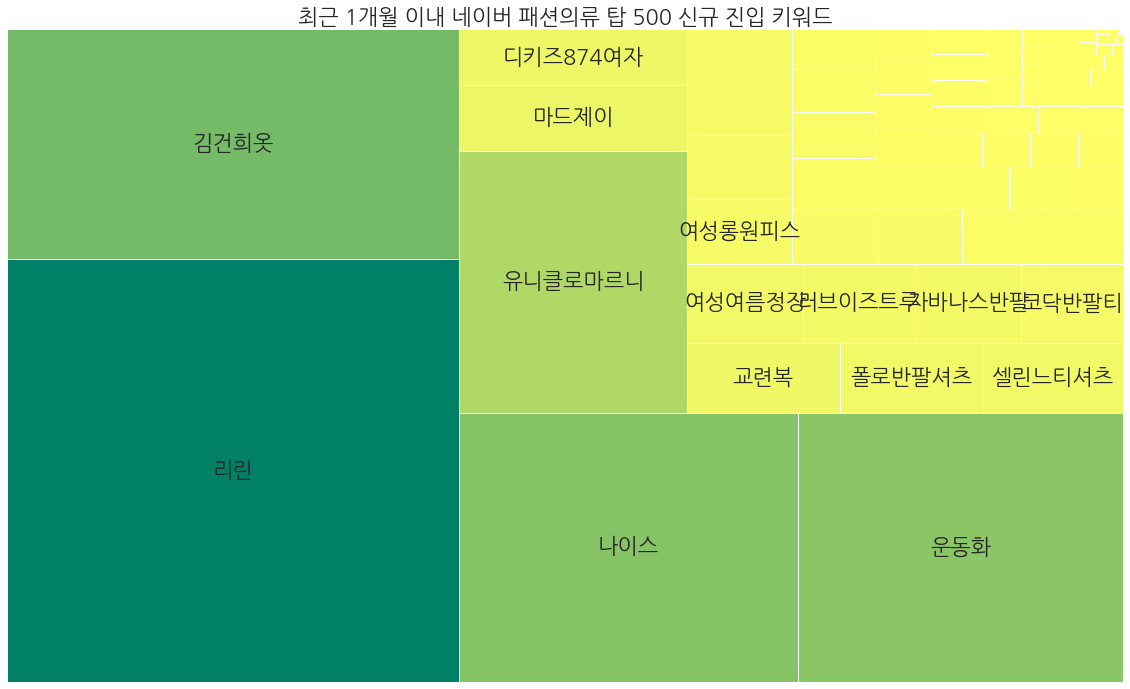

In [107]:
# 색상지도 시각화
cmap = matplotlib.cm.summer_r
norm = matplotlib.colors.Normalize(vmin=shapes.month_avg_query.min(), vmax=shapes.month_avg_query.max())
colors = [cmap(norm(value)) for value in shapes.month_avg_query]

# 연도별 블로그, 카페 건수 트리맵
plt.figure(figsize=(20,12)); plt.axis('off') ; plt.title("최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드")
squarify.plot(
    sizes=shapes.month_avg_query,
    color=colors,
    label=shapes.apply(lambda x: str(x.keyword) if x.month_avg_query >= 1 else '', axis=1),
    alpha=1)
